# 2D molecular dynamics

Atomic simulation using the Morse potential:

https://en.wikipedia.org/wiki/Morse_potential

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate, optimize, spatial
from matplotlib import animation, rc
import sympy as sp
sp.init_printing(use_latex = "mathjax")
#from IPython.display import HTML
rc('animation', html='html5')
%matplotlib nbagg

## Potential

In [2]:
De, a, re, r = sp.symbols("D_e a r_e r")
V = De * ((1- sp.exp(-a * (r-re)))**2 -1)
V

   ⎛                  2    ⎞
   ⎜⎛     -a⋅(r - rₑ)⎞     ⎟
Dₑ⋅⎝⎝1 - ℯ           ⎠  - 1⎠

## Force

In [3]:
F = -V.diff(r).simplify()
F

        ⎛ a⋅(r - rₑ)    ⎞  -2⋅a⋅(r - rₑ)
-2⋅Dₑ⋅a⋅⎝ℯ           - 1⎠⋅ℯ             

## Plotting

In [4]:
values = {De:1., a:1., re:1}
Vf = sp.lambdify(r, V.subs(values), "numpy")
Ff = sp.lambdify(r, F.subs(values), "numpy")
vr = np.linspace(.3 * values[re], 5 * values[re], 100)
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
plt.plot(vr, Vf(vr))
plt.grid()
plt.ylabel("Potential Value, $V$")
ax = fig.add_subplot(2,1,2)
plt.plot(vr, Ff(vr))
plt.grid()
plt.xlabel("Interatomic Distance, $r$")
plt.ylabel("Force Value, $F$")
plt.show()

<IPython.core.display.Javascript object>

In [45]:
class Morse:
    """
    A force meta class
    """
    
    def __init__(self, De = 1., a = 1., re = 1., mu = 0.):
        self.De = De
        self.a = a
        self.re = re
        self.mu = mu
    
    def set_balls(self, balls):
        """
        Sets the balls instance to work with
        """
        self.balls = balls
    
    def force(self):
        De, a, re, mu = self.De, self.a, self.re, self.mu
        P, V = self.balls.positions(), self.balls.speeds()
        #n = len(P)
        #F = np.zeros_like(P)
        """
        for i in range(n): # On s'intéresse à la masse i
            for j in range(n): # Les masses j agissent dessus   
                if i != j: # i ne doit pas agir sur i !
                    PiPj = P[j] - P[i]
                    Rij = (PiPj**2).sum()**.5
                    if Rij != 0.:           
                        Uij = PiPj / Rij
                        F[i] += 2. * De * a * ( np.exp(a * (Rij - re)) -1 ) * np.exp(-2 * a * (Rij-re)) * Uij
        """
        D, R, U = self.balls.distances()
        F = np.where(R[:,:,np.newaxis] != 0.,
             (2. * De * a * ( np.exp( a * (R - re)) -1 ) * np.exp(-2 * a * (R - re)))[:,:,np.newaxis] * U, 
             0.).sum(axis = 0)
        F -= V * mu
        return F
     
    
    
class Balls(object):
    """
    Multibody simulation dynamics simulation.
    """
    def __init__(self, m, P0, V0, interaction, nk = 1000):
        n = len(m)
        self.X = np.zeros([nk, 4 * n])
        self.X.fill(np.NAN)
        self.X[-1, :2 * n] = np.array(P0).flatten()
        self.X[-1, 2 * n:] = np.array(V0).flatten()
        self.m = m
        interaction.set_balls(self)
        self.interaction = interaction
        self.nk = nk
 
    def derivative(self, X, t):
        """
        ODE
        """      
        m = self.m
        n = len(m)
        V = self.speeds()
        A = (self.interaction.force().T / m).T
        X2 = X.copy()
        X2[:2*n ] = V.flatten()
        X2[ 2*n:] = A.flatten()
        return X2       
    
    def positions(self):
        """
        Returns the current positions.
        """
        n = len(self.m)
        return self.X[-1, :2 * n ].reshape(n ,2)
  
    def speeds(self):
        """
        Returns the current speeds.
        """
        n = len(self.m)
        return  self.X[-1, 2 * n:].reshape(n ,2)
    
    def distances(self):
        """
        Return vectorials distance, scalar distance and normalized directions.
        """
        P = self.positions()
        X, Y = P.T
        dX = X - X[:, np.newaxis]
        dY = Y - Y[:, np.newaxis]
        D = np.array([dX, dY]).swapaxes(0,2)
        R = np.sqrt(D[:,:,0]**2 + D[:,:,1]**2)
        U = np.divide(D, 
            R[:,:,np.newaxis], 
            out=np.zeros_like(D), 
            where=R[:,:,np.newaxis] != 0.)
        return D, R, U
    
    def solve(self, dt, nt, **kwargs):
        time = np.linspace(0., dt, nt + 1)
        Xs = integrate.odeint( self.derivative, self.X[-1], time, **kwargs)
        nk = self.nk
        X = self.X
        X[:nk - nt] = X[nt:]
        X[-nt-1:] = Xs 
        self.X    = X
  
    def xy(self):
        P = self.positions()
        return P[:,0], P[:,1]
    
    def trail(self, i):
        n = len(self.m)
        X = self.X
        return X[:, 2*i], X[:, 2*i +1 ]


             

<IPython.core.display.Javascript object>


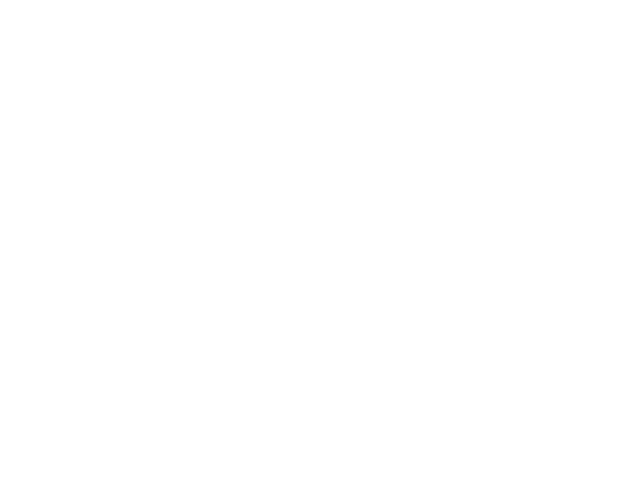

In [77]:
nr = 8
nt = 20
nm = nr * nt
m = np.ones(nm)*1.e0
"""
P0 = (np.random.rand(nm, 2)-.5) *.5
V0 = np.zeros_like(P0)
"""
theta = np.linspace(0., 2. * np.pi, nt, endpoint = False)
rmax = 1.
r = np.linspace(0., rmax, nr+1)[1:]
Theta, R = np.meshgrid(theta, r)
Theta = Theta.flatten()
R = R.flatten()
V = 4*R
V *= .6
V += np.random.rand(len(V))*0.3 
X  =   R * np.cos(Theta)
Y  =   R * np.sin(Theta)
Vx = - V * np.sin(Theta)
Vy =   V * np.cos(Theta)
P0 = np.array([X,   Y]).transpose()
V0 = np.array([Vx, Vy]).transpose()
colors = "rb"

morse = Morse(mu = 6., re = .8)

s = Balls(m, P0, V0, interaction = morse, nk = 500)      
dt = 0.02
nt = 100
s.solve(dt, nt)


from matplotlib import animation
fig = plt.figure("Le systeme solaire")
plt.clf()
ax = fig.add_subplot(1,1,1)
ax.set_aspect("equal")
plt.xlim(-1., 1.)
plt.ylim(-1., 1.)
plt.grid()
ax.axis("off")
planets = []

msize = 10. * (s.m / s.m.max())**(1./6.)
for i in range(nm):
  lc = len(colors)
  c = colors[i%lc]
  planet, = ax.plot([], [], "o"+c, markersize = msize[i])
  planets.append(planet)
  trail, = ax.plot([], [], "-"+c)
  planets.append(trail)
  
def init():
  for i in range(2 * nm):
    planets[i].set_data([], [])
    return planets 
    
def animate(i):
    s.solve(dt, nt)#, rtol = 1.e-8, atol = 1.e-8)
    x, y = s.xy()
    for i in range(nm):
      planets[2*i].set_data(x[i:i+1], y[i:i+1])
      xt, yt = s.trail(i)
      planets[2*i+1].set_data(xt, yt)
    return planets 

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=400, interval=20, blit=True)

#anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])        

plt.close()
anim

#plt.show()